In [2]:
import scipy
import numpy as np 
import pandas as pd 
import scipy.interpolate
from scipy.stats import mode
import matplotlib.pyplot as plt
from pycaret.classification import * 
from sklearn.utils.fixes import loguniform
from scipy.ndimage.interpolation import shift

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
# Reading training data and saving it as .npy file for future use ( takes a bit too long)
path = r'iitmee4708\Training Dataset\character_' # change to the path where you stored the data
D = []
for l in range(10):
    fp = path + str(l) + '\\'
    ds = []
    for i in range(1, 1001):
        d = pd.read_csv(fp + str(i) + '.csv', header = None)
        ds.append(np.array(d))
    D.append(ds) 

data = np.array(D)
np.save('data', data) 

In [ ]:
# Reading test data in proper format and saving it in feather format for future use

test = pd.read_csv(r'iitmee4708\public_test.csv', header = None)
X_test = pd.DataFrame([test.iloc[:,i].to_numpy().reshape(28,28).T.flatten() for i in range(test.shape[1])])
X_test.columns = X_test.columns.astype(str)
X_test.to_feather('test_new')

### Data Cleaning 

In [2]:
data = np.load('data.npy') # find original code

In [3]:
def clean_image(d):
    """
    strategy = nearest neighbor interpolation
    input    = noisy image numpy matrix
    output   = imputed image numpy matrix
    """
    mask = ~(np.isnan(d))
    xx, yy = np.meshgrid(np.arange(d.shape[1]), np.arange(d.shape[0]))
    xym = np.vstack( (np.ravel(xx[mask]), np.ravel(yy[mask])) ).T

    data0 = np.ravel(d[mask]) 
    interp0 = scipy.interpolate.NearestNDInterpolator(xym, data0 ) 
    result = interp0(np.ravel(xx), np.ravel(yy)).reshape( xx.shape )
    return result

In [4]:
#cleaning the data
m, n = data.shape[0], data.shape[1]

for i in range(m):
    for j in range(n):
        image = data[i][j]
        clean = clean_image(image)
        data[i][j] = clean

In [ ]:
# saving the cleaned file in .npy and feather format for future use
np.save('clean_data', data)
df_train = pd.DataFrame(data)
labels = []
for i in range(10):
    labels.extend([i]*1000)
df_train['labels'] = labels
df_train.columns = df_train.columns.astype(str)
df_train.to_feather('cleaned_train')

### Data Splitting

In [3]:
trainData = pd.read_feather('cleaned_train') # put in savefiles folder
trainData = trainData.sample(frac = 1).reset_index(drop = True)
test = (pd.read_feather('test_new')) / 255  # min max scaling for test

In [4]:
x = (trainData.drop('labels', axis = 1)) / 255 # min max scaling
y = trainData['labels'].copy()

In [5]:
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 42)

### Algorithm shortlisting

In [ ]:
# pycaret helps shortlist classification models
# then choose well performing allowed models
exp_clf = setup(trainData, target = 'labels')
best = compare_models() # will take a lot of time

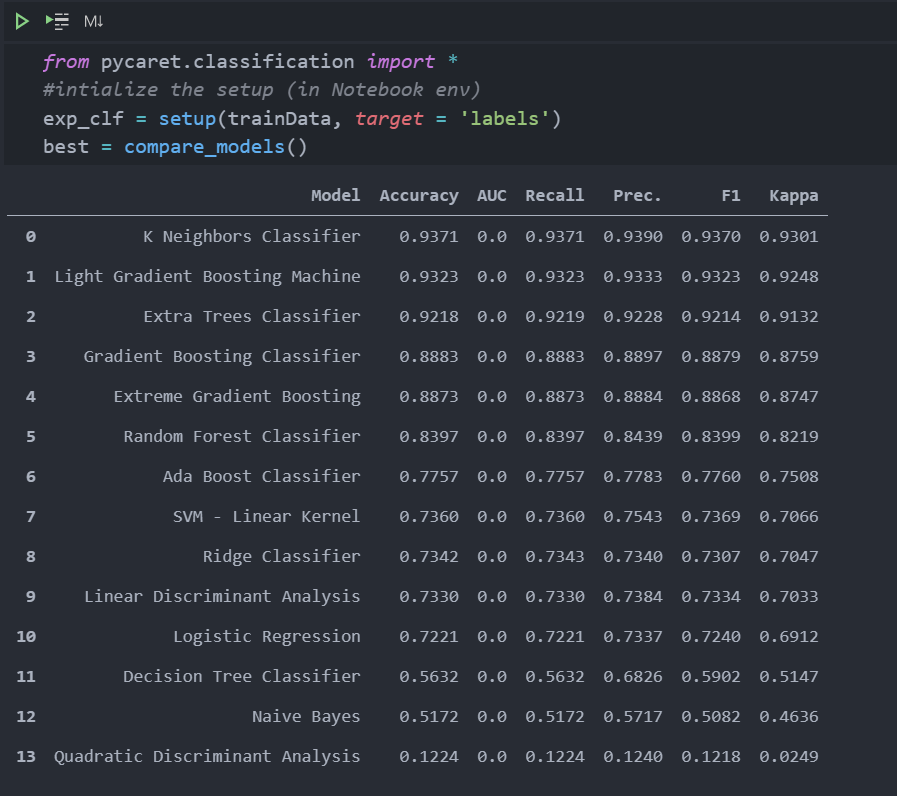

In [4]:
## showing already ran result
from IPython.display import Image
Image(filename='pycaret_result.png', height =1, width =1) 

### Model selection

### Random Forest

In [46]:
# random search for approximate best hyperparameters
params = {
    'n_estimators': range(200, 1000, 50),
    'max_depth': range(20, 100, 10),
    'min_samples_leaf': range(2, 10, 2),
    'min_samples_split': range(1, 5)
}

clf = RandomForestClassifier(random_state = 42)
rdm_clf = RandomizedSearchCV(clf, n_iter = 100, verbose = 2, cv = 3,
                             param_distributions = params, n_jobs = -1)

In [47]:
rdm_clf.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.4min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': range(20, 100, 10),
                                        'min_samples_leaf': range(2, 10, 2),
                                        'min_samples_split': range(1, 5),
                                        'n_estimators': range(50, 1000, 50)},
                   verbose=2)

In [68]:
rdm_results = pd.DataFrame(rdm_clf.cv_results_)
rdm_results = rdm_results.nsmallest(3, 'rank_test_score')
rdm_results[[
    'param_n_estimators', 'param_min_samples_split','param_min_samples_leaf', 
    'param_max_depth', 'mean_test_score', 'std_test_score', 'rank_test_score'
]]

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,mean_test_score,std_test_score,rank_test_score
87,900,2,2,30,0.913625,0.001394,1
67,800,2,2,20,0.913000,0.000546,2
21,850,4,2,50,0.912875,0.001290,3


In [89]:
# grid search for fine searching hyperparameters
params = {
    'n_estimators': [880, 890, 900],
    'max_depth': [23, 25, 27],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [2, 3]
}

clf = RandomForestClassifier(random_state = 42)
grid_clf = GridSearchCV(clf, params, cv = 3, n_jobs = -1)

In [90]:
grid_clf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [25, 30, 35], 'min_samples_leaf': [2],
                         'min_samples_split': [2], 'n_estimators': [890]})

In [91]:
grid_clf.best_params_ 

{'max_depth': 25,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 890}

In [92]:
grid_clf.best_estimator_.fit(X_train, y_train)
y_train_preds = grid_clf.best_estimator_.predict(X_train)
train_acc = np.mean(y_train_preds == y_train)
train_acc

1.0

In [93]:
y_val_preds = grid_clf.best_estimator_.predict(X_val)
val_acc = np.mean(y_val_preds == y_val)
val_acc

0.927

In [94]:
val_score = f1_score(y_val, y_val_preds, average = 'macro')
train_score = f1_score(y_train, y_train_preds, average = 'macro')

train_score, val_score

(1.0, 0.9268429744613245)

### KNN

In [6]:
# random search for approximate best hyperparameters
params = {
    'n_neighbors': range(2, 20),
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
}

clf = KNeighborsClassifier(n_jobs = -1)
rdm_clf = RandomizedSearchCV(clf, n_iter = 20, verbose = 2, cv = 3,
                             param_distributions = params, n_jobs = -1)

In [7]:
rdm_clf.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  7.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  7.3min finished


RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(n_jobs=-1), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'n_neighbors': range(2, 20),
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   verbose=2)

In [12]:
rdm_results = pd.DataFrame(rdm_clf.cv_results_)
rdm_results = rdm_results.nsmallest(3, 'rank_test_score')
rdm_results[[
    'param_weights', 'param_p', 'param_n_neighbors', 'mean_test_score', 'std_test_score', 'rank_test_score'
]]

,param_weights,param_p,param_n_neighbors,mean_test_score,std_test_score,rank_test_score
7,distance,2,2,0.933000,0.001687,1
5,distance,1,5,0.922125,0.003234,2
14,uniform,2,5,0.920626,0.003359,3


In [13]:
# grid search for fine searching hyperparameters
params = {
    'n_neighbors': range(2, 6),
    'p': [1, 2],
    'weights': ['distance', 'uniform']
}

clf = KNeighborsClassifier(n_jobs = -1)
grid_clf = GridSearchCV(clf, params, n_jobs = -1)

In [14]:
grid_clf.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'n_neighbors': range(2, 6), 'p': [1, 2],
                         'weights': ['distance', 'uniform']})

In [15]:
grid_clf.best_params_ # n_estimators = 300, max_depth = 24

{'n_neighbors': 2, 'p': 2, 'weights': 'distance'}

In [16]:
grid_clf.best_estimator_.fit(X_train, y_train)
y_train_preds = grid_clf.best_estimator_.predict(X_train)
train_acc = np.mean(y_train_preds == y_train)
train_acc

1.0

In [17]:
y_val_preds = grid_clf.best_estimator_.predict(X_val)
val_acc = np.mean(y_val_preds == y_val)
val_acc

0.9515

In [18]:
val_score = f1_score(y_val, y_val_preds, average = 'macro')
train_score = f1_score(y_train, y_train_preds, average = 'macro')

train_score, val_score

(1.0, 0.9510223852243824)

### SVC

In [5]:
# random search for approximate best hyperparameters
params = {
    'degree': range(1, 7),
    'C': loguniform(1e-1, 1e3),
    'gamma': loguniform(1e-2, 1e3),
    'kernel': ['linear', 'rbf', 'poly'],
}

clf = SVC()
rdm_clf = RandomizedSearchCV(clf, n_iter = 20, verbose = 2, cv = 3,
                             param_distributions = params, n_jobs = -1)

In [ ]:
rdm_clf.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.1min


In [ ]:
rdm_results = pd.DataFrame(rdm_clf.cv_results_)
rdm_results = rdm_results.nsmallest(3, 'rank_test_score')
rdm_results[[
    'param_kernel', 'param_gamma', 'param_C', 'param_degree','mean_test_score', 'std_test_score', 'rank_test_score'
]]

In [93]:
# grid search for fine searching hyperparameters
params = {
    'C': [5, 10, 15],
    'kernel': ['poly'],
    'gamma': [5, 10, 15],
    'degree': [2, 3]
}

clf = SVC()
grid_clf = GridSearchCV(clf, params, n_jobs = -1)

In [94]:
grid_clf.fit(X_train, y_train)

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [10], 'degree': [2], 'gamma': [10],
                         'kernel': ['poly']})

In [95]:
grid_clf.best_params_

{'C': 10, 'degree': 2, 'gamma': 10, 'kernel': 'poly'}

In [96]:
grid_clf.best_estimator_.fit(X_train, y_train)
y_train_preds = grid_clf.best_estimator_.predict(X_train)
train_acc = np.mean(y_train_preds == y_train)
train_acc

1.0

In [97]:
y_val_preds = grid_clf.best_estimator_.predict(X_val)
val_acc = np.mean(y_val_preds == y_val)
val_acc

0.9575

In [98]:
val_score = f1_score(y_val, y_val_preds, average = 'macro')
train_score = f1_score(y_train, y_train_preds, average = 'macro')

train_score, val_score

(1.0, 0.9571816038828802)

### Voting model - evaluation

In [15]:
def voting(rf, knn, svm, data):
    """
    majority vote classifier (knn decides in ties)
    inputs  = trained RF, KNN, SVM models, dataset (dataframe/numpy) 
    output  = predicted labels (0-9) in a list
    """
    d = pd.DataFrame()
    d['rf']  = rf.predict(data)
    d['knn'] = knn.predict(data)
    d['svm'] = svm.predict(data)
    
    votedPred = []
    for i in range(len(d)):
        row = d.iloc[i]
        count = mode(row).count[0] 
        if count == 1:
            votedPred.append(row['knn'])
        else:
            votedPred.append(mode(row)[0][0])
            
    return votedPred

### Data Augmentation

In [33]:
def shift_image(image, dx, dy):
    """
    right-shifts the image by dx pixels and upshifts by dy pixels
    inputs  = image numpy matrix, dx (int), dy (int)
    output  = shifted image numpy matrix 
    """
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval = 0, mode="constant")
    return shifted_image.reshape([-1])

In [44]:
x = np.array(x)
y = np.array(y)

X_augmented = []
y_augmented = []

# shifting by 1 pixel in all 4 directions
for i in range(x.shape[0]):
    for dx, dy in [(-1, 0), (1, 0), (0, 1), (0, -1)]: 
        X_augmented.append(shift_image(x[i, :], dx, dy))
        y_augmented.append(y[i])

In [35]:
X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

### Train models on Augmented data

In [36]:
svm = SVC(C = 10, degree = 2, gamma = 10, kernel = 'poly')
svm.fit(X_augmented, y_augmented)

SVC(C=10, degree=2, gamma=10, kernel='poly')

In [37]:
rf = RandomForestClassifier(max_depth = 25, min_samples_leaf = 2, min_samples_split = 2, n_estimators = 890)
rf.fit(X_augmented, y_augmented)

RandomForestClassifier(max_depth=25, min_samples_leaf=2, n_estimators=890)

In [38]:
knn = KNeighborsClassifier(n_neighbors = 2, p = 2, weights = 'distance')
knn.fit(X_augmented, y_augmented)

KNeighborsClassifier(n_neighbors=2, weights='distance')

In [47]:
votedPred = voting(rf, knn, svm, test)

In [43]:
# for kaggle submission
sub = pd.read_csv('pred.csv')
sub['Expected'] = votedPred
sub.to_csv('pred.csv', index = False)

### Required Function 

In [20]:
import pickle

def predict_private_dataset(location):
    """
    give predictions on private test set
    input  = file location of models and data (string)
    output = predicted labels (numpy array) 
    
    Note: Keep pickle files and csv file at this location
    """
    data = pd.read_csv(location + '/private_test.csv')/255  #min max scaling

    # print(data.head())
    ## opening 3 models
    file = open(location + '/rf.pickle', 'rb')
    rf = pickle.load(file)

    file = open(location + '/knn.pickle', 'rb')
    knn = pickle.load(file)

    file = open(location + '/svm.pickle', 'rb')
    svm = pickle.load(file) 

    predicted_class = voting(rf, knn, svm, data)
    # If data frame is required comment out the below codes 
    # sub = pd.Dataframe()
    # id_ = []
    # for i in range(len(data)):
    #     id_.append('Sample_'+ str(i+1))
    # sub['Id'] = id_
    # sub['Expected'] = predicted_class
    # return sub
    return np.array(predicted_class)